# Marketing Campaign Analysis — Is Saturday Really Better?
**Goal:** Test a marketing claim using hypothesis testing on conversion data.

 1) Business Question
A marketing manager claims that users who saw the most ads on **Saturday** converted more than users who saw the most ads on other days.

We want to validate this claim using statistical hypothesis testing.

---

 2) Dataset
This project uses a marketing A/B dataset with the following columns:

- `user id`: unique user identifier  
- `test group`: experiment group (`ad` vs `psa`)  
- `converted`: whether the user converted (`True/False`)  
- `total ads`: total number of ads shown to the user  
- `most ads day`: day of week when the user saw the most ads  
- `most ads hour`: hour of day when the user saw the most ads  

> Note: This analysis focuses on **conversion behavior by day (Saturday vs Others)**.  
> We do **not** need a price column because our target metric is binary conversion.

---

 3) Metric Definition
### Conversion Rate
Conversion Rate is defined as:

\[
Conversion\ Rate = \frac{\#Converted}{\#Total\ Users}
\]

Where `converted = True` means the user performed the desired action (e.g., purchase, signup, etc.).

---

 4) Hypotheses (One-sided)
We compare two groups:

- **Group 1:** Users where `most ads day = Saturday`
- **Group 2:** Users where `most ads day ≠ Saturday`

Let:

- \(p_{Sat}\) = conversion rate among Saturday users  
- \(p_{Others}\) = conversion rate among users from other days  

### Null Hypothesis (H0)
\[
H_0: p_{Sat} \le p_{Others}
\]

### Alternative Hypothesis (H1)
\[
H_1: p_{Sat} > p_{Others}
\]

This is **one-sided** because the claim explicitly states Saturday performs better.

---

 5) Statistical Test Choice
Because `converted` is binary (True/False), we compare **two proportions**.

✅ **Two-Proportion Z-Test** is appropriate for comparing conversion rates between two groups.




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [6]:
df = pd.read_csv("/Users/zohrehsamieekadkani/Desktop/Dashboard image/A-B-Test/marketing_AB.csv")  

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df["converted"] = df["converted"].astype(int)

df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,0,130,Monday,20
1,1119715,ad,0,93,Tuesday,22
2,1144181,ad,0,21,Tuesday,18
3,1435133,ad,0,355,Tuesday,10
4,1015700,ad,0,276,Friday,14


In [7]:
df.info()
df.isna().sum()
df["most ads day"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  int64 
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 26.9+ MB


most ads day
Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: count, dtype: int64

In [8]:
# converted can be True/False; convert to 1/0
df["converted"] = df["converted"].astype(int)

df["converted"].value_counts()

converted
0    573258
1     14843
Name: count, dtype: int64

In [9]:
df["is_saturday"] = (df["most ads day"] == "Saturday").astype(int)

sat = df[df["is_saturday"] == 1]
others = df[df["is_saturday"] == 0]

len(sat), len(others)

(81660, 506441)

In [10]:
summary = pd.DataFrame({
    "group": ["Saturday", "Other days"],
    "users": [len(sat), len(others)],
    "converted": [sat["converted"].sum(), others["converted"].sum()]
})

summary["conversion_rate"] = summary["converted"] / summary["users"]
summary

,group,users,converted,conversion_rate
0,Saturday,81660,1719,0.021051
1,Other days,506441,13124,0.025914


In [11]:
successes = np.array(summary["converted"])
nobs = np.array(summary["users"])

# one-sided: Saturday > Others
z_stat, p_val = proportions_ztest(count=successes, nobs=nobs, alternative="larger")

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value (one-sided): {p_val:.5f}")

Z-statistic: -8.223
P-value (one-sided): 1.00000


In [12]:
ci = []
for i in range(2):
    low, high = proportion_confint(successes[i], nobs[i], alpha=0.05, method="wilson")
    ci.append((low, high))

summary["ci_low"] = [ci[0][0], ci[1][0]]
summary["ci_high"] = [ci[0][1], ci[1][1]]
summary

,group,users,converted,conversion_rate,ci_low,ci_high
0,Saturday,81660,1719,0.021051,0.020088,0.022058
1,Other days,506441,13124,0.025914,0.025480,0.026355


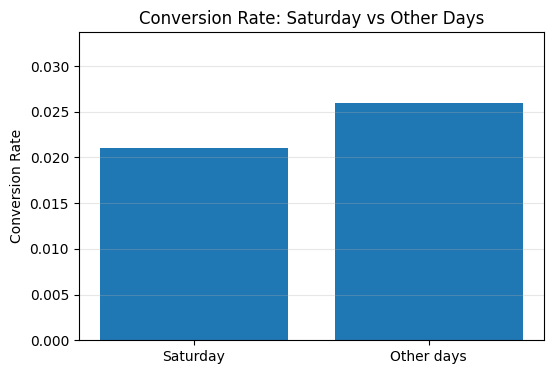

In [13]:
plt.figure(figsize=(6,4))
plt.bar(summary["group"], summary["conversion_rate"])
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate: Saturday vs Other Days")
plt.ylim(0, summary["conversion_rate"].max() * 1.3)
plt.grid(axis="y", alpha=0.3)
plt.show()

## Conclusion

In this analysis, we tested the marketing claim that users who saw the highest number of ads on **Saturday** converted more than users exposed on other days.

### Key Results
- **Saturday Conversion Rate:** 2.11%  
  *(95% CI: 2.01% – 2.21%)*  
- **Other Days Conversion Rate:** 2.59%  
  *(95% CI: 2.55% – 2.64%)*  

A one-sided **Two-Proportion Z-Test** was performed with the alternative hypothesis that Saturday has a higher conversion rate than other days. The results were:

- **Z-statistic:** -8.223  
- **P-value:** 1.00000  

### Interpretation
The conversion rate for Saturday is clearly **lower** than the conversion rate for the rest of the week. Additionally, the 95% confidence intervals for the two groups do not overlap, indicating that the difference is robust and unlikely to be due to random variation.

### Final Decision
Since the p-value is much greater than 0.05, we **fail to reject the null hypothesis**. Therefore, the marketing claim that Saturday generates higher conversions is **not supported by the data**. In fact, the data suggests that Saturday performs worse than other days in terms of conversion rate.

### Business Recommendation
Based on these findings, allocating a larger advertising budget specifically to Saturdays is not recommended without further investigation. A better strategy may be to focus ad delivery on other days with higher observed conversion rates, or to perform additional segmentation analysis (e.g., by test group, ad exposure level, or hour of day).